Disclaimer :  This is purely an assigned research thus use this with a word of caution from my side

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polyphase
import numpy as np
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

In [3]:
# Figuring out upper hull using the normals
from scipy.spatial import ConvexHull

def get_lower_convexhull(points):
    inf_ind = np.shape(points)[0]
    base_points = points[:,:-1].mean(axis=0)
    inf_height = 1e10*abs(max(points[:,-1]))
    p_inf = np.hstack((base_points,inf_height))
    points_inf = np.vstack((points,p_inf))
    hull = ConvexHull(points_inf)
    lower = ~(hull.simplices==inf_ind).any(axis=1)
    lower_hull = hull.simplices[lower]
    
    return lower_hull,points_inf


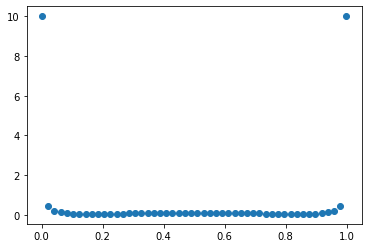

In [4]:
# sample a two-component FH
def f(x):
    x1 = x
    x2 = np.abs(1-x1).astype(float)
    chi = 3
    beta = 1e-2
    entropy = (x1*np.log(x1)) + (x2*np.log(x2))
    enthalpy = chi*x1*x2
    beta_correction = beta*(1/x1 + 1/x2)
    
    return entropy+enthalpy+beta_correction

def sample_double_well(num):
    x = np.linspace(1e-3,0.999,num=num)
    e = f(x)
    points = np.stack((x,e),axis=1)
    
    return points
points = sample_double_well(50)
plt.scatter(points[:,0],points[:,1])
plt.show()

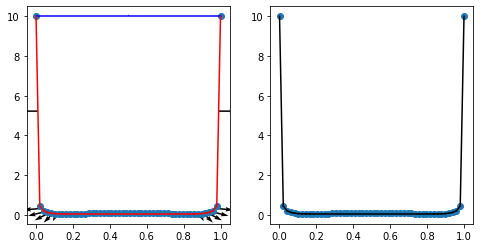

In [5]:
# 2D example of Upper Hull and Lower Hull
#points = np.random.rand(30,2)
points = sample_double_well(50)
hull = ConvexHull(points)
fig, axs = plt.subplots(1,2,figsize=(2*4,4))
axs[0].plot(points[:,0], points[:,1], 'o')
for equation,simplex in zip(hull.equations,hull.simplices):
    X,Y = points[simplex].mean(axis=0)
    U,V,_ = equation
    if V>=0:
        color = 'b-'
    else:
        color = 'r-'
    axs[0].plot(points[simplex, 0], points[simplex, 1], color)    
    axs[0].quiver(X,Y,U,V,scale=10,scale_units='xy')

lower_hull,_ = get_lower_convexhull(points)
axs[1].plot(points[:,0], points[:,1], 'o')
for simplex in lower_hull:
    axs[1].plot(points[simplex, 0], points[simplex, 1], 'k-')
    
plt.show()

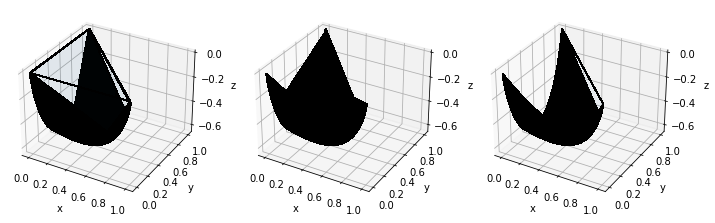

In [6]:
grid = polyphase.makegridnd(200,3)
M, chi = polyphase.get_sample_data(1)
f = lambda x : polyphase.flory_huggins(x, M, chi)
energy = np.asarray([f(x) for x in grid.T])
points = np.concatenate((grid[:-1,:].T,energy.reshape(-1,1)),axis=1)

hull = ConvexHull(points)
lower_hull, points_inf = get_lower_convexhull(points)
zlower = hull.equations[:,-2]<0

fig, axs = plt.subplots(1,3,figsize=(3*4,4),subplot_kw={'projection':'3d'})
triangles = [hull.simplices, lower_hull,hull.simplices[zlower]]
for i in range(3):
    #axs[i].scatter(points[:,0], points[:,1],points[:,2],alpha=0.1)
    axs[i].plot_trisurf(points[:,0],points[:,1],points[:,2],triangles=triangles[i],
                    linewidth=1.0,edgecolor='k', antialiased=False,facecolor='grey',alpha=0.05)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_zlabel('z')
    
plt.show()

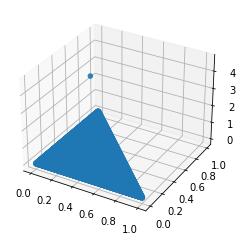

In [7]:
fig, ax = plt.subplots(subplot_kw = {'projection':'3d'})
ax.scatter(points_inf[:,0], points_inf[:,1],points_inf[:,2])
plt.show()

Computation took 5.54s


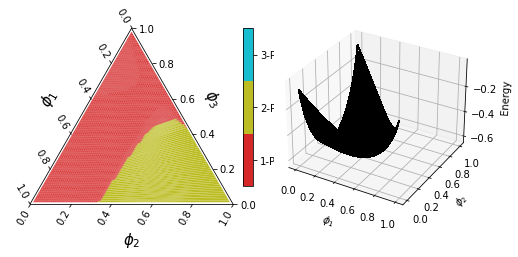

Computation took 5.86s
[ 954 2838 5049] 
 [[9.0909091e-01 9.0909100e-02 1.0000000e-08]
 [6.6666667e-01 3.3333334e-01 1.0000000e-08]
 [1.0000000e-08 1.0000000e+00 1.0000000e-08]] 

[29 99  0] 
 [[2.9292930e-01 1.0000000e-08 7.0707071e-01]
 [1.0000000e+00 1.0000000e-08 1.0000000e-08]
 [1.0000000e-08 1.0000000e-08 1.0000000e+00]] 

[2422 5049    0] 
 [[1.0000000e-08 2.8282829e-01 7.1717172e-01]
 [1.0000000e-08 1.0000000e+00 1.0000000e-08]
 [1.0000000e-08 1.0000000e-08 1.0000000e+00]] 



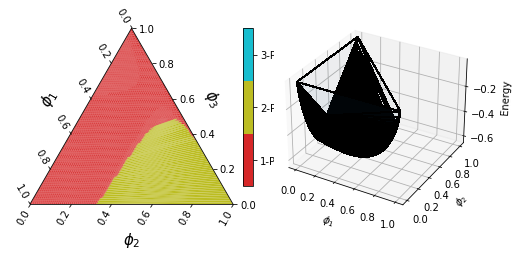

Computation took 5.95s
[1563 5049   99] 
 [[8.3838384e-01 1.6161617e-01 1.0000000e-08]
 [1.0000000e-08 1.0000000e+00 1.0000000e-08]
 [1.0000000e+00 1.0000000e-08 1.0000000e-08]] 

[1563 2838 5049] 
 [[8.3838384e-01 1.6161617e-01 1.0000000e-08]
 [6.6666667e-01 3.3333334e-01 1.0000000e-08]
 [1.0000000e-08 1.0000000e+00 1.0000000e-08]] 

[58 99  0] 
 [[5.8585859e-01 1.0000000e-08 4.1414142e-01]
 [1.0000000e+00 1.0000000e-08 1.0000000e-08]
 [1.0000000e-08 1.0000000e-08 1.0000000e+00]] 

[1890 5049    0] 
 [[1.0000000e-08 2.1212122e-01 7.8787879e-01]
 [1.0000000e-08 1.0000000e+00 1.0000000e-08]
 [1.0000000e-08 1.0000000e-08 1.0000000e+00]] 



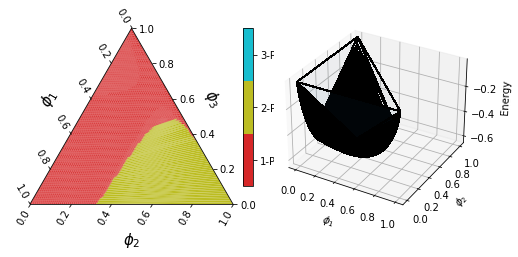

In [8]:
methods = [None, 'point_at_infinity','negative_znorm']
corrections = [1,2,2]
M, chi = polyphase.get_sample_data(1)
f = lambda x : polyphase.flory_huggins(x, M, chi)
for i in range(3):
    engine = polyphase.PHASE(f,100,len(M))
    engine.compute(correction=corrections[i], lower_hull_method=methods[i])
    phase3 = engine.simplices[np.asarray(engine.num_comps)==3]
    for p3 in phase3:
        print(p3,'\n', engine.grid[:,p3].T,'\n')
    renderer = polyphase.TernaryPlot(engine)
    fig = plt.figure(figsize=(2*4,4))
    ax = fig.add_subplot(1,2,1,projection='ternary')
    renderer.plot_simplices(ax=ax,label=True)
    ax = fig.add_subplot(1,2,2, projection='3d')
    polyphase.plot_energy_landscape(engine.as_dict(),mode='convex_hull',ax=ax)
    plt.show()

Computation took 2.81s
Computation took 2.72s
Computation took 2.69s


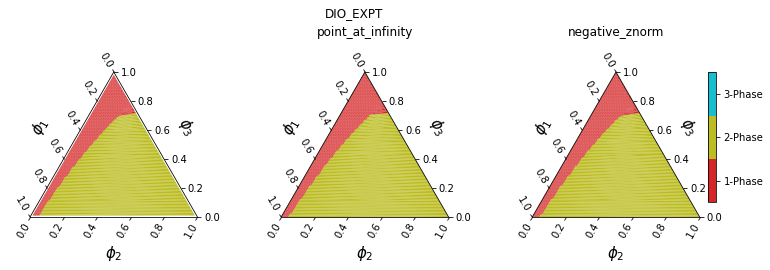

In [9]:
import pickle
import pandas as pd

dirname = '../data/hamming/pm6y6'
distmats = dirname + '/distance.pkl'

with open(distmats, 'rb') as handle:
    out = pickle.load(handle)

def evaluate_hull_methods(M,chi):
    f = lambda x : polyphase.flory_huggins(x, M, chi)
    fig = plt.figure(figsize=(3*4,4))
    fig.subplots_adjust(wspace=0.5)
    methods = [None,'point_at_infinity','negative_znorm']
    corrections = [1,3,3]
    engines = {}
    for i,method in enumerate(methods):
        engine = polyphase.PHASE(f,100,len(M))
        engine.compute(correction=corrections[i], lower_hull_method=method)
        engines[i] = engine
        renderer = polyphase.TernaryPlot(engine)

        ax = fig.add_subplot(1,3,i+1,projection='ternary')
        ax, cbar = renderer.plot_simplices(ax=ax,label=True)
        if i!=2:
            cbar.remove()
        ax.set_title(method,pad=36)
    
    return fig, ax, cbar, engines
 
sys_df = out['df'].reset_index(drop=True)
for _, row in sys_df[86:].iterrows():
    M = row['dop']
    chi = [row['chi12'],row['chi13'],row['chi23']]
    fig, ax, cbar,_ = evaluate_hull_methods(M,chi)
    fig.suptitle(row['solvent'])
    plt.show()
    break

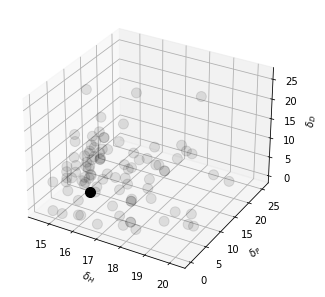

In [11]:
df

,index,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer,MVol
0,28,Acetone,Y6,PM6,0.379771,1.896708,2.393527,"[1120.632256490311, 14.404273188350158, 1]","[15.5, 10.4, 7.0]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",73.8
1,70,Acetonitrile,Y6,PM6,0.368508,4.562997,5.101974,"[1563.3773256896964, 20.095186413993225, 1]","[15.3, 18.0, 6.1]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",52.9
2,112,n-Amyl Acetate,Y6,PM6,0.419757,1.015023,1.370306,"[558.8017603309794, 7.182671360136768, 1]","[15.8, 3.3, 6.1]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",148.0
3,154,n-Amyl Alcohol,Y6,PM6,0.398525,4.813878,5.723564,"[761.5346273387196, 9.788539238492097, 1]","[15.9, 5.9, 13.9]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",108.6
4,196,Benzene,Y6,PM6,0.368508,0.844891,0.684596,"[1563.3773256896964, 20.095186413993225, 1]","[18.4, 0.0, 2.0]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",52.9
...,...,...,...,...,...,...,...,...,...,...,...,...
91,3850,CN_EXPT,Y6,PM6,0.413452,0.639918,0.510620,"[606.7693362361331, 7.799232291271032, 1]","[19.9, 4.9, 2.5]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",136.3
92,3892,Tol_EXPT,Y6,PM6,0.397447,0.925263,0.699690,"[775.8223314163691, 9.972189130396265, 1]","[18.0, 1.4, 2.0]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",106.6
93,3934,PDMS_EXPT,Y6,PM6,0.390279,1.238633,1.221719,"[886.4165115646831, 11.393733775994015, 1]","[16.0, 0.1, 4.7]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",93.3
94,3976,NMP_EXPT,Y6,PM6,0.391842,3.126127,3.761478,"[859.6950158938142, 11.050263630979641, 1]","[18.0, 12.3, 7.2]","[18.98, 3.72, 3.44]","[18.37, 4.36, 4.19]",96.2


Computation took 1.49s
Computation took 1.20s
Computation took 1.20s


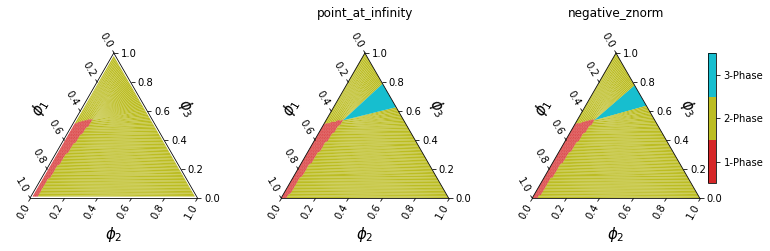

In [36]:
M = [406.193,5.99,1]
chi = [0.435,0.77,1.00]
fig, ax, cbar, engines = evaluate_hull_methods(M,chi)
plt.show()

In [37]:
from autograd import jacobian
import autograd.numpy as anp
import pprint

def f(x):
    x1,x2 = x
    x3 = anp.abs(1-x1-x2).astype(float)
    entropy = (x1*anp.log(x1))/M[0] + (x2*anp.log(x2))/M[1] + (x3*anp.log(x3))/M[2]
    enthalpy = chi[0]*x1*x2 + chi[1]*x1*x3 + chi[2]*x2*x3
    
    return entropy+enthalpy
gradient = lambda x : jacobian(f)(np.asarray(x)[:-1])

818 [7.45829987e-01 1.15068609e-10 2.52583775e-01]


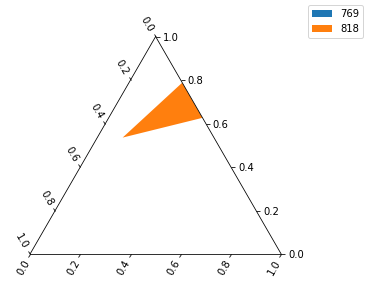

{769: ['The chosen simplex with vertices [[6.1616162e-01 1.0000000e-08 '
       '3.8383839e-01]\n'
       ' [4.9494950e-01 1.0000000e-08 5.0505051e-01]\n'
       ' [1.0000000e-08 1.0000000e-08 1.0000000e+00]] is flat.The tests cannot '
       'be performed.',
       'The chosen simplex with vertices [[6.1616162e-01 1.0000000e-08 '
       '3.8383839e-01]\n'
       ' [4.9494950e-01 1.0000000e-08 5.0505051e-01]\n'
       ' [1.0000000e-08 1.0000000e-08 1.0000000e+00]] is flat.The tests cannot '
       'be performed.'],
 818: [[1.0, 1.0, 1.0], False]}


In [38]:
engine = engines[1]
results = {}
PHASE_ID = 3
phase_simplex_ids = np.where(np.asarray(engine.num_comps)==PHASE_ID)[0]
fig, ax = plt.subplots(subplot_kw={'projection':'ternary'})
for simplex_id in phase_simplex_ids:
    # 1. performing tangent normal test
    try:
        angles = polyphase.TestAngles(engine,phase=PHASE_ID,simplex_id=simplex_id)
        angles_out = angles.get_angles(gradient)
        TestAngles_dotprods = [t[-1] for _,t in angles_out['thetas'].items()] 
    except Exception as err :
        TestAngles_dotprods = str(err)
        
    # 2. Perform phase splitting test
    try:
        phasesplits = polyphase.TestPhaseSplits(engine,phase=PHASE_ID,simplex_id=simplex_id, threshold=0.05)
        TestPhaseSplits_centroid = phasesplits.check_centroid()
        print(simplex_id, phasesplits.centroid_splits_)
    except Exception as err :
        TestPhaseSplits_centroid = str(err)
        
    v = engine.grid[:,engine.simplices[simplex_id]]
    ax.fill(v[2,:], v[0,:], v[1,:], label=str(simplex_id))
    results[simplex_id] = [TestAngles_dotprods,TestPhaseSplits_centroid]
fig.legend()
plt.show()

pprint.pprint(results)

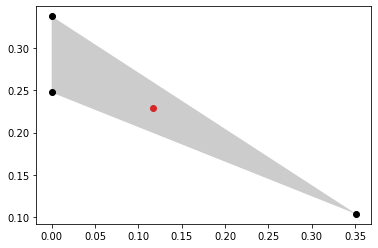

In [33]:
phasesplits.visualize_centroid()

In [ ]:
fig = plt.figure(figsize=(3*4,4))
fig.subplots_adjust(wspace=0.5)
for i,e in engines.items():
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    #polyphase.plot_energy_landscape(e.as_dict(),mode='full', ax=ax)
    polyphase.plot_energy_landscape(e.as_dict(),mode='full', ax=ax)
plt.show()